## Hail product comparison
#### This notebook generates plots of the gridded crowdsourced hail size for multiple events, and investigates different versions (including a version without radar-filter and a version with directional interpolation)


In [1]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import geopandas as gpd
from sklearn.cluster import DBSCAN

from climada import CONFIG
import scClim as sc
import seaborn as sns

data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)

In [2]:
#Read in the Swiss borders
gdf = gpd.read_file(f"{str(CONFIG.ch_shp_path)}/swissTLMRegio_LANDESGEBIET_LV95.shp")
#Read in modelled vs observed damages
imp_dfPAA = pd.read_csv(f"{data_dir}/crowd-source/imp_dfs/V{27}_PAAflex_noBias.csv",
                        index_col=0,parse_dates=['date'],infer_datetime_format=True)
#Read in gridded hazard data
ds_main=xr.open_dataset(f'{data_dir}/crowd-source/Reports_min25_2020+_V{27}.nc')
ds_main = ds_main.rename({'time':'date'})

In [3]:
# Load the building damage data from KGV (building insurance union),
# post-processed with date correction (final version V7.1, which ends in 2023)
ds_KGV = xr.open_dataset(data_dir+'/KGV/ds_building_dmg_v71_1000m.nc')
ds_KGV = ds_KGV.rename({'value':'imp_observed'})
ds_KGV['PAA'] = ds_KGV['PAA'].clip(0,1) #very few erroneous entries with >0
ds_KGV = ds_KGV.sel(date=slice('2020-08-01','2023-09-30'))

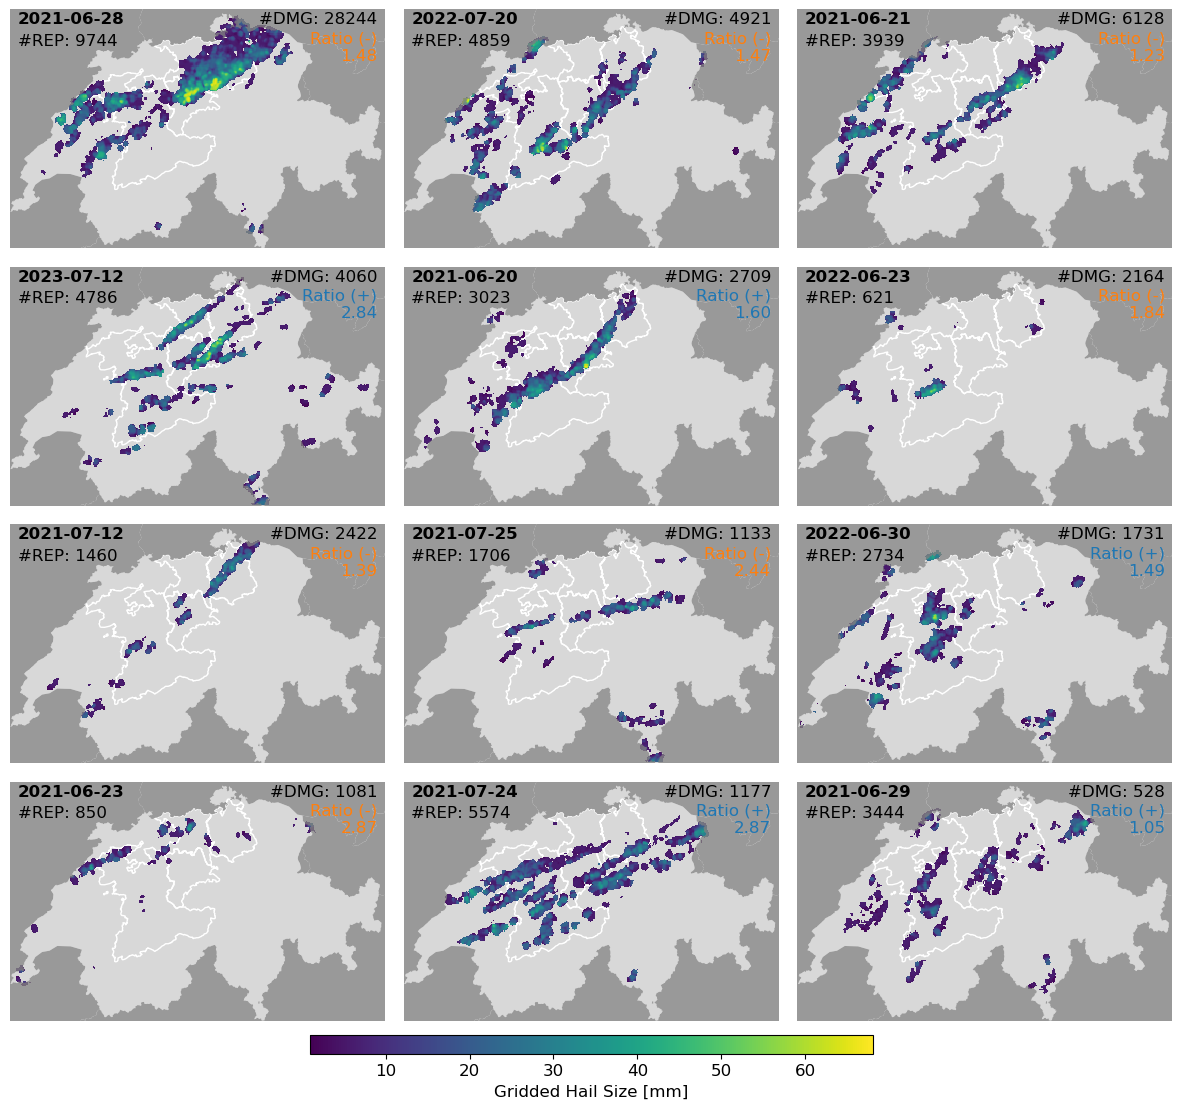

In [ ]:
# Select X dates with the largest reported damage
args= ds_KGV['imp_observed'].sum(dim=['chy','chx']).argsort()
ordered_dates = ds_KGV.date.values[args[::-1]]

# #select X dates with most reports (over Switzerland)
# args = ds_main.n_rep.sum(['chx','chy']).argsort()
# ordered_dates = ds_main.date.values[args[::-1]]

n_rows = 4
n_cols = 3
n_tot = n_rows*n_cols

cmap = sns.color_palette('viridis',as_cmap=True)
cmap.set_under('white',alpha=0)
fig, axes = plt.subplots(n_rows,n_cols,figsize=(15,4*n_rows),
                         subplot_kw={'projection': ccrs.epsg(2056)},
                         gridspec_kw={'hspace':-0.44,'wspace':0.05})

for row in range(n_rows):
    for col in range(n_cols):
        date = ordered_dates[row*n_cols+col]

        #Plot the gridded hail size
        _,pl = sc.plot_nc(ds_main.h_smooth.sel(date=date),ax=axes[row,col],borders=False,
                        vmin=1,vmax=68,cbar=False,return_plot=True,cmap=cmap)

        #Add date and total number of reports
        axes[row,col].text(0.02,0.99,f"{str(date).split('T')[0]}",transform=axes[row,col].transAxes,
                        ha='left',va='top',fontsize=12,rotation='horizontal',weight='bold')
        tot_n_rep = ds_main.n_rep.sel(date=date).sum(['chx','chy']).values
        axes[row,col].text(0.02,0.9,f"#REP: {tot_n_rep:.0f}",transform=axes[row,col].transAxes,
                        ha='left',va='top',fontsize=12,rotation='horizontal')

        #Add total number of damage claims
        tot_n_count = ds_KGV['n_count'].sel(date=date).sum()
        axes[row,col].text(0.98,0.99,f"#DMG: {tot_n_count:.0f}",transform=axes[row,col].transAxes,
                        ha='right',va='top',fontsize=12,rotation='horizontal')

        #Select dataframe with modelled and observed damage
        df_now = imp_dfPAA.loc[imp_dfPAA['date'] == date]
        ratio = (df_now['imp_obs']/df_now['imp_modelled']).values[0]
        if ratio<1:
            color = 'tab:blue'
            ratio_str = f"Ratio (+)\n{1/ratio:.2f}"
        else:
            color = 'tab:orange'
            ratio_str = f"Ratio (-)\n{ratio:.2f}"
        axes[row,col].text(0.98,0.91,ratio_str,transform=axes[row,col].transAxes,
                        ha='right',va='top',fontsize=12,rotation='horizontal',color=color)

        #In the last row plot the colorbar
        if row == n_rows-1 and col==1:
            sc.plot_funcs.add_cbar_v2(fig,axes[row,col],pl,labelsize=12,
                                      label='Gridded Hail Size [mm]',x0=-0.25,
                                      y0=-0.14,dx=1.5,dy=0.08)

#Add canton borders and Swiss borders
for ax in axes.flatten():
    sc.plot_canton(ax,ch_border='none',canton=['Zürich','Bern','Luzern','Aargau'],
                   lakes=False,edgecolor='white')
    gdf[gdf.ICC != 'CH'].plot(ax=ax,color='grey',edgecolor='none',alpha=0.8)
    gdf[gdf.ICC == 'CH'].plot(ax=ax,color='grey',edgecolor='none',alpha=0.3,
                              zorder=0)
    ax.axis('off')

fig.savefig(f'{out_dir}/paper_crowd/hail_size_examples.png',dpi=300,bbox_inches='tight')

### Check how many reports are removed with 4d-dbscan, but without MESHS filter

In [5]:
#Load crowdsourced data
crowd_data = pd.read_csv(f'{data_dir}/crowd-source/crowd_processed_paper.csv',parse_dates=['time_dt','hailday'])
crowd_data = crowd_data.rename(columns={"Unnamed: 0": "UniqueID"})
assert crowd_data.shape[0] == crowd_data.UniqueID.nunique()
crowd_data['hailday'] = crowd_data.hailday.dt.date # Convert datetime to date

#Remove all entries before (and including) July 2020
crowd_data = crowd_data[crowd_data.hailday.apply(pd.Timestamp).dt.date >= dt.date(2020,8,1)]
#Only keep values within hail season April-September
crowd_data = crowd_data[crowd_data.hailday.apply(pd.Timestamp).dt.month.isin([4,5,6,7,8,9])]
#remove no hail category
crowd_data = crowd_data.loc[crowd_data.size_text!='No hail']
tot_unfiltered_reps = crowd_data.shape[0]
print("Total number of unfiltered reports: ",tot_unfiltered_reps)
#Analyse reports below dBZ35 (basic plausibility filter)
# crowd_data = crowd_data.loc[crowd_data['FILTEREDOUT']==0]
tot_non_dBZ35_reports = (crowd_data['FILTEREDOUT']==1).sum()
print(f"Total number of reports not within the 35dBZ criteria: {tot_non_dBZ35_reports}."
      f" These are not removed here, as they will automacially be removed with the POH/MESHS filter.")



#Coffe bean reports must be within POH
cond1 = crowd_data.size_mm.between(2.5,6.5) & (crowd_data.maxBZC_t15_r4>0) # 2.5mm="<coffe bean", 6.5mm ="coffe bean"
tot_poh_filtered = ((crowd_data.size_mm.between(2.5,6.5)) & ~(crowd_data.maxBZC_t15_r4>0)).sum()
print(f"Removed based on POH: {tot_poh_filtered}")
#1 Franc and larger must be within MESHS
cond2 = (crowd_data.size_mm>=23) & (crowd_data.maxMZC_t15_r4>0)
tot_meshs_filtered = ((crowd_data.size_mm>=23) & ~(crowd_data.maxMZC_t15_r4>0)).sum()
print(f"Removed based on MESHS: {tot_meshs_filtered}")

crowd_data["time_int"] = crowd_data.time_dt.astype("int64")//10**9
crowd_data["time_int"] = crowd_data["time_int"] - crowd_data["time_int"].min()

#Split into two versions with or without MESHS filtering
crowd_data_with_MESHSfilter = crowd_data.loc[cond1|cond2]

filtered_dfs = dict()
for df,text in zip([crowd_data_with_MESHSfilter,crowd_data],['MESHSfilter','noFilter']):
    dx=8000; d_min = 8; d_size = 1.5
    X = df[['chx','chy','time_int','size']].values
    X = sc.crowd_process.per_category_scaler(X,min_dist_p_category=[dx,dx,d_min*60,d_size]) # km,km, s, #size_categories

    dbscan = DBSCAN(eps=1,min_samples=5)
    dbscan.fit(X)
    df['cluster'] = dbscan.labels_
    crowd_data_cluster = df.copy(deep=True) #Create copy for later plotting
    print(f"Remove {df[df.cluster==-1].shape[0]} not-clustered reports")
    df = df[df.cluster!=-1]
    print(f"Number of clustered reports: {df.shape[0]}")
    filtered_dfs[text] = df




C:\Users\timschmi\AppData\Local\Temp\ipykernel_2664\3429764110.py:2: DtypeWarning: Columns (10,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  crowd_data = pd.read_csv(f'{data_dir}/crowd-source/crowd_processed_paper.csv',parse_dates=['time_dt','hailday'])


Total number of unfiltered reports:  180478
Total number of reports not within the 35dBZ criteria: 28384. These are not removed here, as they will automacially be removed with the POH/MESHS filter.
Removed based on POH: 36390
Removed based on MESHS: 21964
Remove 15873 not-clustered reports
Number of clustered reports: 106224
Remove 63360 not-clustered reports
Number of clustered reports: 117118


In [6]:
#Calculate the total number of reports that are filtered by the radar+DBSCAN filter
tot_filtered_DBSCANonly = tot_unfiltered_reps-filtered_dfs['noFilter'].shape[0]
tot_filtered_MESHSpDBSCAN = tot_unfiltered_reps-filtered_dfs['MESHSfilter'].shape[0]
print(f"Total number of reports removed with DBSCAN only: {tot_filtered_DBSCANonly},"
      f" MESHS+DBSCAN: {tot_filtered_MESHSpDBSCAN}")

Total number of reports removed with DBSCAN only: 63360, MESHS+DBSCAN: 74254


In [8]:
#Get dataframe of reports that are filtered with MESHS filter but not filtered without
# Get all IDs from the MESHSfilter dataframe
meshs_filter_ids = set(filtered_dfs['MESHSfilter']['UniqueID'])
# Filter the noFilter dataframe to get rows not in MESHSfilter
df_diff = filtered_dfs['noFilter'][~filtered_dfs['noFilter']['UniqueID'].isin(meshs_filter_ids)]
df_diff.size_mm.value_counts()

2.5     5461
6.5     2438
23.0    2434
32.0     338
43.0     161
68.0      62
Name: size_mm, dtype: int64

In [9]:
additional_DBSCAN_filtered = tot_poh_filtered+tot_meshs_filtered-df_diff.shape[0]
print(f"Number of reports additonally removed with DBSCAN without MESHS pre-filtering: "
      f"{additional_DBSCAN_filtered}, fraction of total MESHS/POH-filtered reports: "
      f"{additional_DBSCAN_filtered/(tot_poh_filtered+tot_meshs_filtered):.0%}")


Number of reports additonally removed with DBSCAN without MESHS pre-filtering: 47460, fraction of total MESHS/POH-filtered reports: 81%


## Plot of different versions (with directional interpolation)

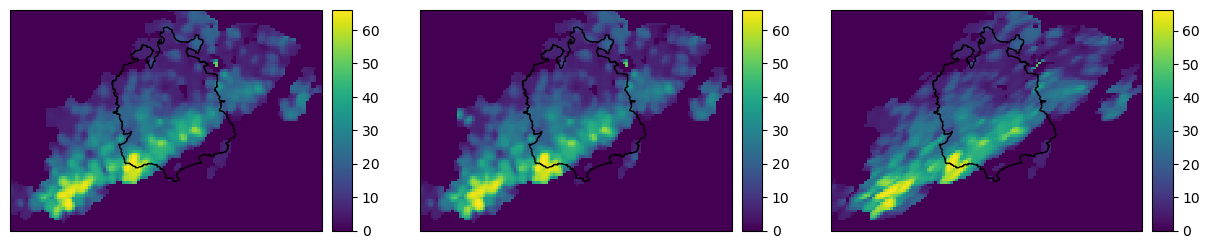

In [11]:
ds_main=xr.open_dataset(f'{data_dir}/crowd-source/Reports_min25_2020+_V{27}.nc').rename({'time':'date'})
ds_no_filter = xr.open_dataset(f'{data_dir}/crowd-source/Reports_min25_2020+_V{40}.nc').rename({'time':'date'})
ds_directional = xr.open_dataset(f'{data_dir}/crowd-source/Reports_min25_2020+_V{33}.nc').rename({'time':'date'})

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,6),subplot_kw={'projection': ccrs.epsg(2056)})
sc.plot_nc(ds_main.h_smooth.sel(date="2021-06-28"),ax=ax1,borders=False)
sc.plot_nc(ds_no_filter.h_smooth.sel(date="2021-06-28"),ax=ax2,borders=False)
sc.plot_nc(ds_directional.h_smooth.sel(date="2021-06-28"),ax=ax3,borders=False)
for ax in [ax1,ax2,ax3]:
    sc.plot_canton(ax,ch_border='grey')
    ax.set_extent((2630000.0, 2750000.0, 1205000.0, 1290000.0), crs=ccrs.epsg(2056))

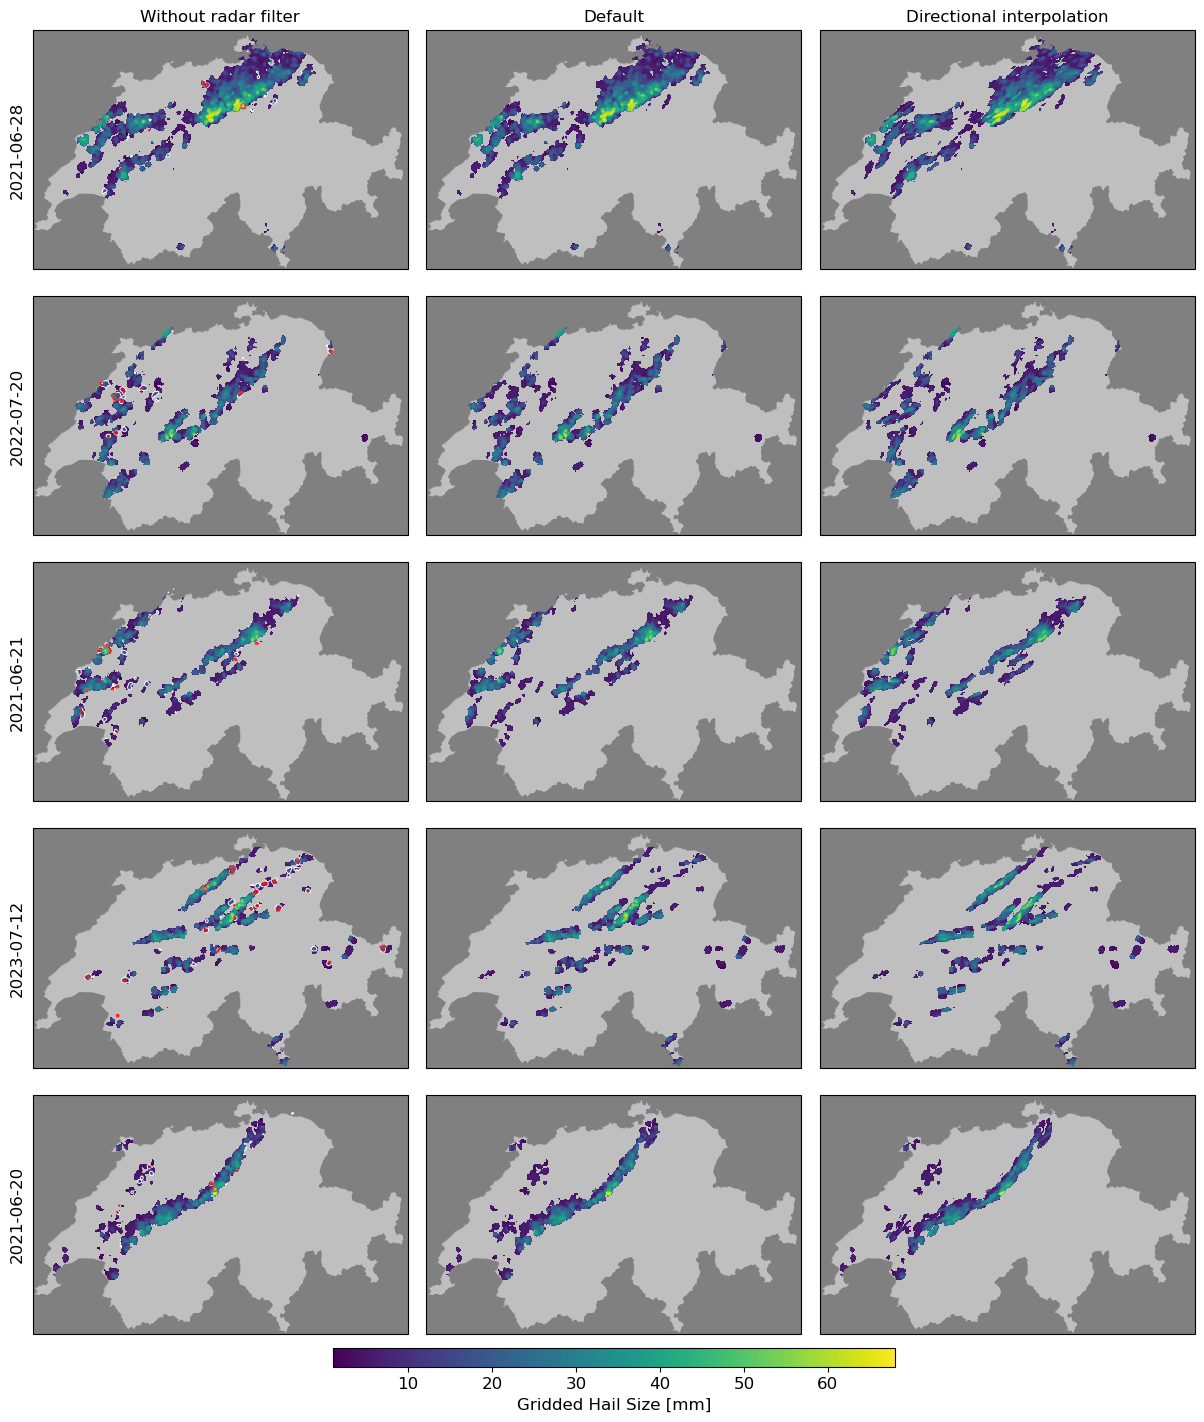

In [12]:

# Select 5 dates with the largest reported damage
args= ds_KGV['imp_observed'].sum(dim=['chy','chx']).argsort()
ordered_dates = ds_KGV.date.values[args[::-1]]

# #select X dates with most reports (over Switzerland)
# args = ds_main.n_rep.sum(['chx','chy']).argsort()
# ordered_dates = ds_main.date.values[args[::-1]]

n_dates = 5
cmap = sns.color_palette('viridis',as_cmap=True)
cmap.set_under('white',alpha=0)
fig, axes = plt.subplots(n_dates,3,figsize=(15,4*n_dates),subplot_kw={'projection': ccrs.epsg(2056)},gridspec_kw={'hspace':-0.44,'wspace':0.05})
for row,date in enumerate(ordered_dates[:n_dates]):
    axes[row,0].text(-0.02,0.5,f"{str(date).split('T')[0]}",transform=axes[row,0].transAxes,
                     ha='right',va='center',fontsize=12,rotation='vertical',)

    for i,ds in enumerate([ds_no_filter,ds_main,ds_directional]):

        # if not i==0:
        _,pl = sc.plot_nc(ds.h_smooth.sel(date=date),ax=axes[row,i],borders=False,
                        vmin=1,vmax=68,cbar=False,return_plot=True,cmap=cmap)

        if i==0:
            delta =  ds_no_filter.h_smooth.sel(date=date) - ds_main.h_smooth.sel(date=date)
            frac = delta/ds_main.h_smooth.sel(date=date) #frac.where(abs(delta)>2)

            #Plot in grey all areas with >5mm difference
            _,pl = sc.plot_nc(delta.fillna(0),ax=axes[row,i],borders=False,
                            cbar=False,return_plot=True,cmap='grey',pl_type='contour',levels=[-5,5],linewidths=0.7) #vmin=-20,vmax=20

            #Plot in grey all areas with >5mm difference, but values below 20
            _,pl = sc.plot_nc(delta.where(ds_no_filter.h_smooth.sel(date=date)>20).fillna(0),ax=axes[row,i],borders=False,
                            cbar=False,return_plot=True,cmap='bwr',pl_type='contour',levels=[-5,5],linewidths=0.7) #vmin=-20,vmax=20
            # if row ==n_dates-1:
            #     sc.plot_funcs.add_cbar_v2(fig,axes[row,i],pl,label='Difference',x0=-0,y0=-0.14,dx=1,dy=0.08,labelsize=12)

        if row == n_dates-1 and i == 1:
            sc.plot_funcs.add_cbar_v2(fig,axes[row,i],pl,label='Gridded Hail Size [mm]',x0=-0.25,y0=-0.14,dx=1.5,dy=0.08,labelsize=12)
        elif row == 0:
            axes[row,i].set_title(['Without radar filter','Default','Directional interpolation'][i],fontsize=12)

for ax in axes.flatten():
    # sc.plot_canton(ax,ch_border='grey',canton=['Zürich','Bern','Luzern','Aargau'],lakes=False,edgecolor='white')
    gdf[gdf.ICC != 'CH'].plot(ax=ax,color='grey',edgecolor='grey')
    gdf[gdf.ICC == 'CH'].plot(ax=ax,color='grey',edgecolor='grey',alpha=0.5,zorder=0)

fig.savefig(f'{out_dir}/paper_crowd/hail_size_products.png',dpi=300,bbox_inches='tight')